In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Allow image embedding in notebook

In [3]:
def load_data(data_dir):
    """
    Loads a data set and returns two lists:
    
    images: a list of numpy array, each representing an image.
    labels: a list of number that represent the image labels.
    
    """
    # Get all subdirectories of data_dir. Each represent a label.
    directories = [d for d in os.listdir(data_dir) if os.path.join(data_dir, d)]
    
    # Loop through the label directories and collect the data in two lists, labels and images
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir,f) for f in os.listdir(label_dir) if f.endswith('.ppm')]
        
        # For each label, load it's image and add them to image list.
        # And add the label number (i,e directory name) to the label list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
            
    return images, labels

# load training and testing datasets.
ROOT_PATH = "/home/test/PycharmProjects/TrafficSignalDetection"
train_data_dir = os.path.join(ROOT_PATH, "data/Training")
test_data_dir = os.path.join(ROOT_PATH, "data/Testing")

images, labels = load_data(train_data_dir)

In [4]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


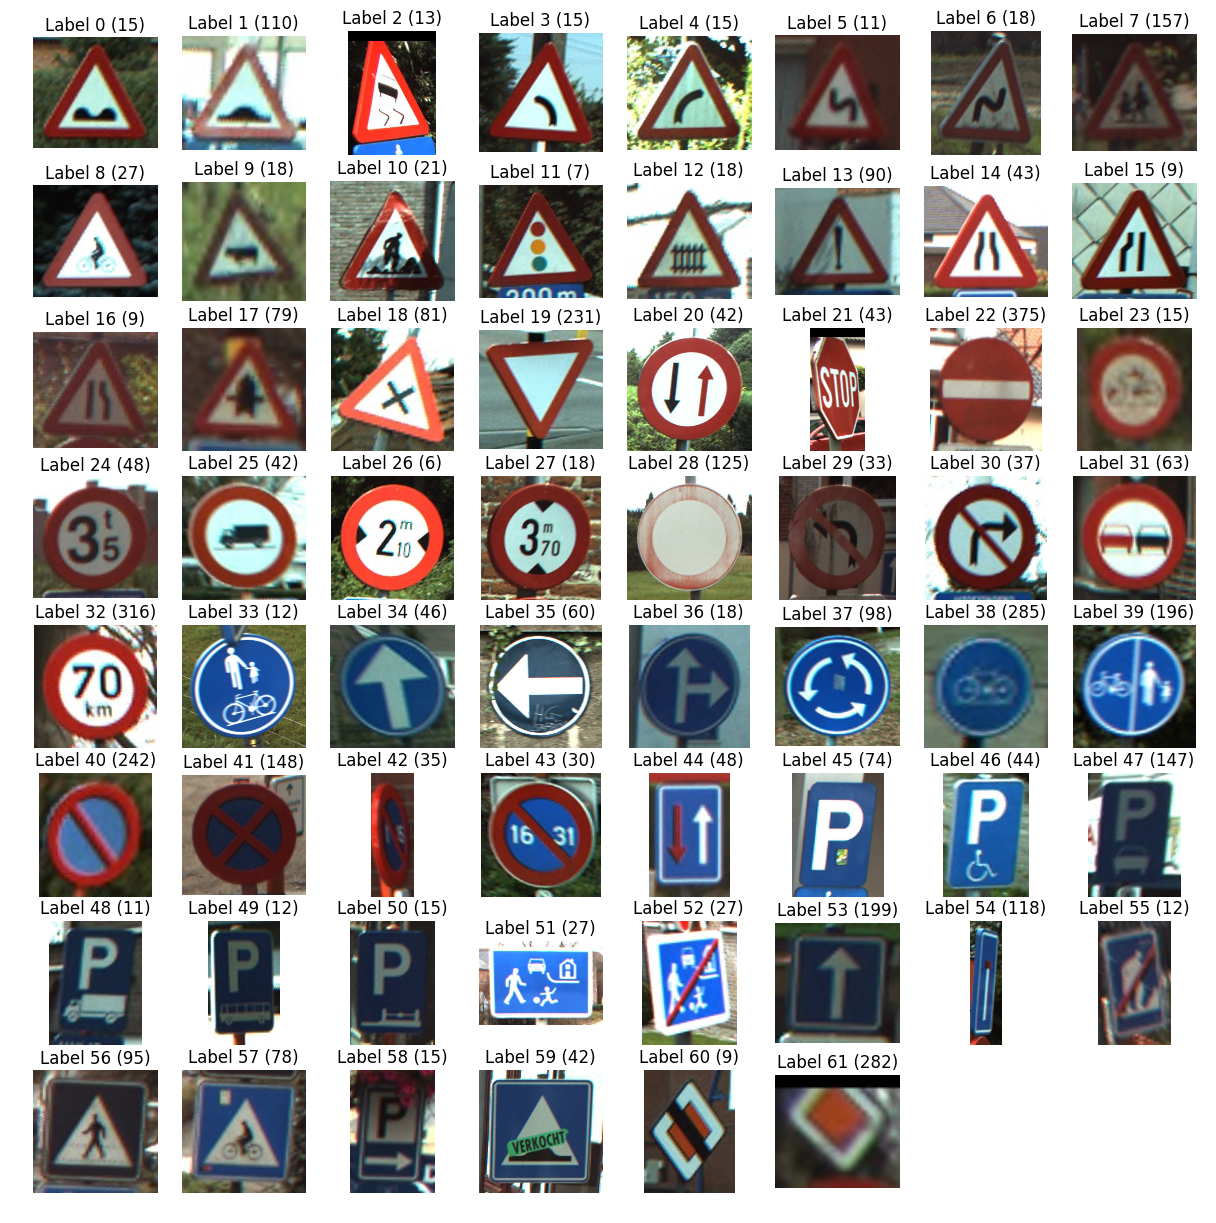

In [5]:
# display few images
def display_images_and_labels(images,labels):
    """ Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15,15))
    i = 1
    for label in unique_labels:
        # pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()
        
display_images_and_labels(images, labels)

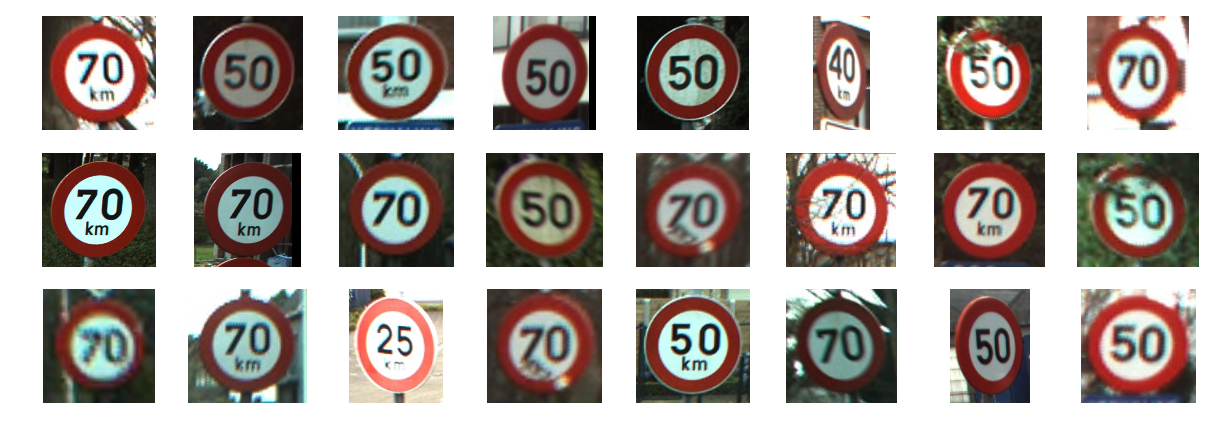

In [6]:
# Let's pick label 32
def display_label_images(images, label):
    """Display images of specific label."""
    limit = 24 # show max of 24 images
    plt.figure(figsize=(15,5))
    i = 1
    
    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

In [7]:
# sizes of our image anyway
for image in images[:5]:
    print("shape: {0}, min: {1}, max:{2}".format(image.shape, image.min(), image.max()))

shape: (372, 363, 3), min: 0, max:255
shape: (367, 417, 3), min: 0, max:255
shape: (153, 144, 3), min: 0, max:255
shape: (118, 121, 3), min: 20, max:114
shape: (60, 51, 3), min: 0, max:255


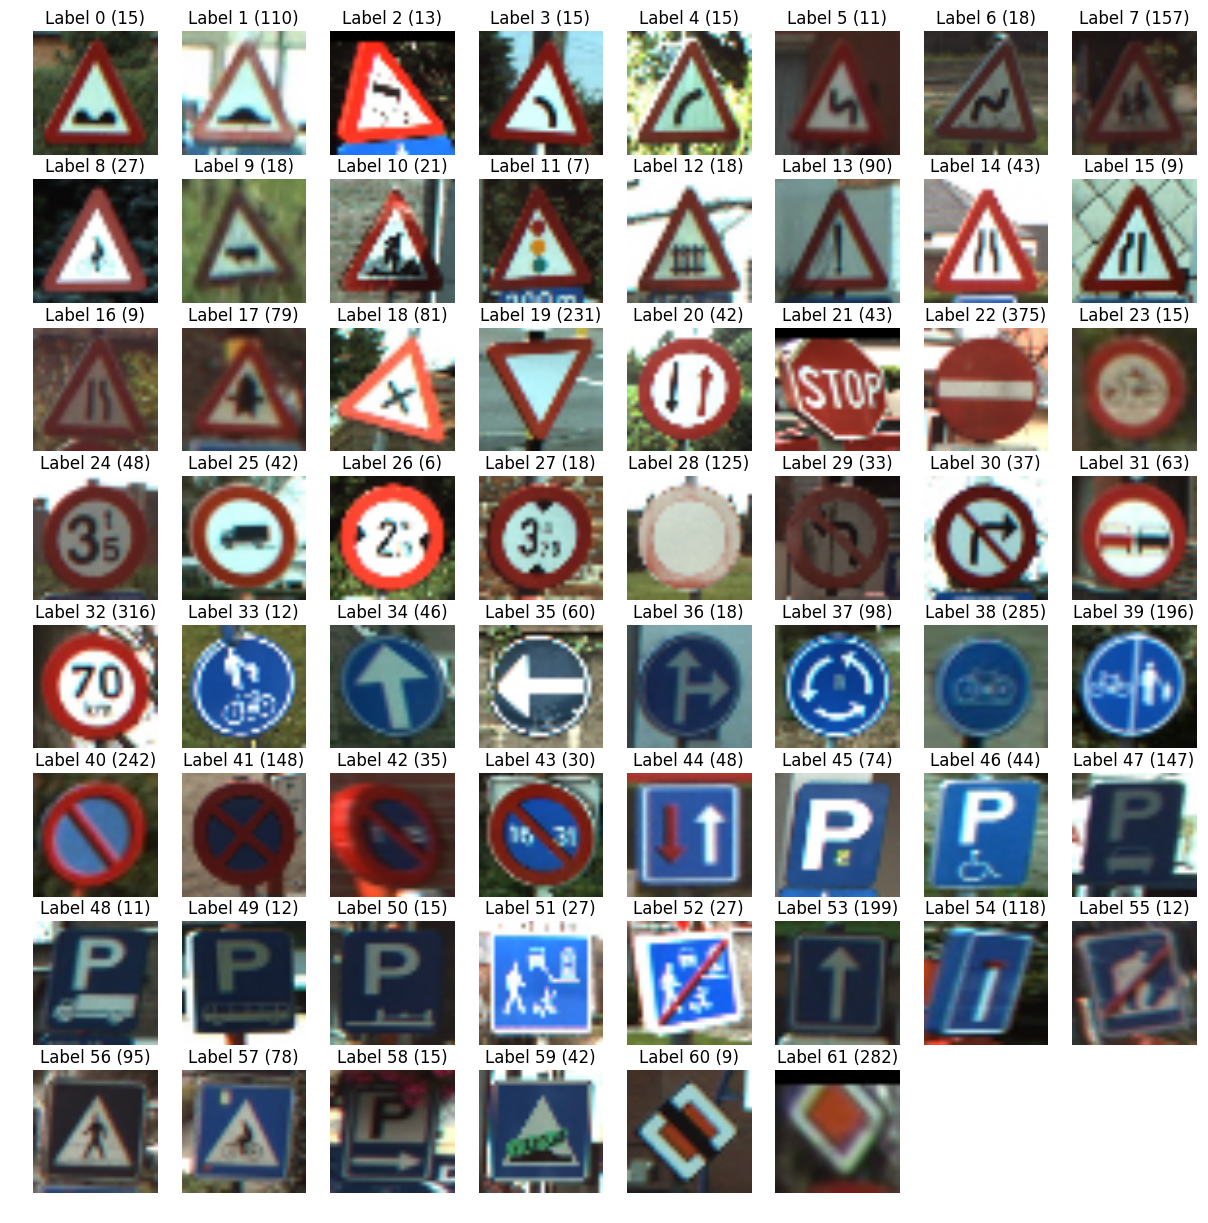

In [8]:
# Resize the images with 32X32 pixel
images32 = [skimage.transform.resize(image,(32,32)) for image in images]

display_images_and_labels(images32, labels)

In [9]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max:{2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.024318321078430676, max:1.0
shape: (32, 32, 3), min: 0.06591509650735405, max:1.0
shape: (32, 32, 3), min: 0.09054840686274503, max:1.0
shape: (32, 32, 3), min: 0.0784313725490196, max:0.44298981311274505
shape: (32, 32, 3), min: 0.018347886029410992, max:1.0


In [14]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [15]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.initialize_all_variables()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
images_flat:  Tensor("Flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [16]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# initialize all variables
_ = session.run([init])

In [17]:
for i in range(201):
    _, loss_value = session.run([train, loss], feed_dict={images_ph: images_a, labels_ph: labels_a})
    
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.25353
Loss:  2.70272
Loss:  2.17096
Loss:  1.93006
Loss:  1.78578
Loss:  1.68537
Loss:  1.60898
Loss:  1.54828
Loss:  1.4983
Loss:  1.45608
Loss:  1.41976
Loss:  1.38804
Loss:  1.36005
Loss:  1.33515
Loss:  1.31282
Loss:  1.29269
Loss:  1.27444
Loss:  1.25783
Loss:  1.24263
Loss:  1.22869
Loss:  1.21584


In [18]:
# Using the model
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the predicted_labels op.
predicted = session.run([predicted_labels], feed_dict={images_ph: sample_images})[0]

print(sample_labels)
print(predicted)

[53, 48, 46, 39, 38, 32, 54, 38, 7, 37]
[53 47 32 22 38 32 54 38  7 37]


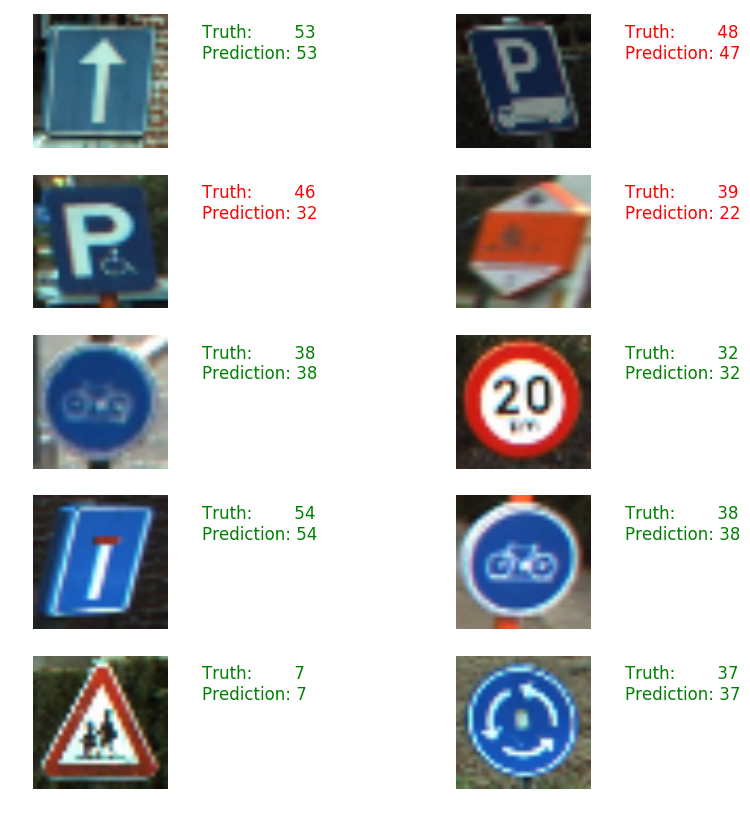

In [24]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), fontsize=12, color=color)
    plt.imshow(sample_images[i])
plt.show()

In [25]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

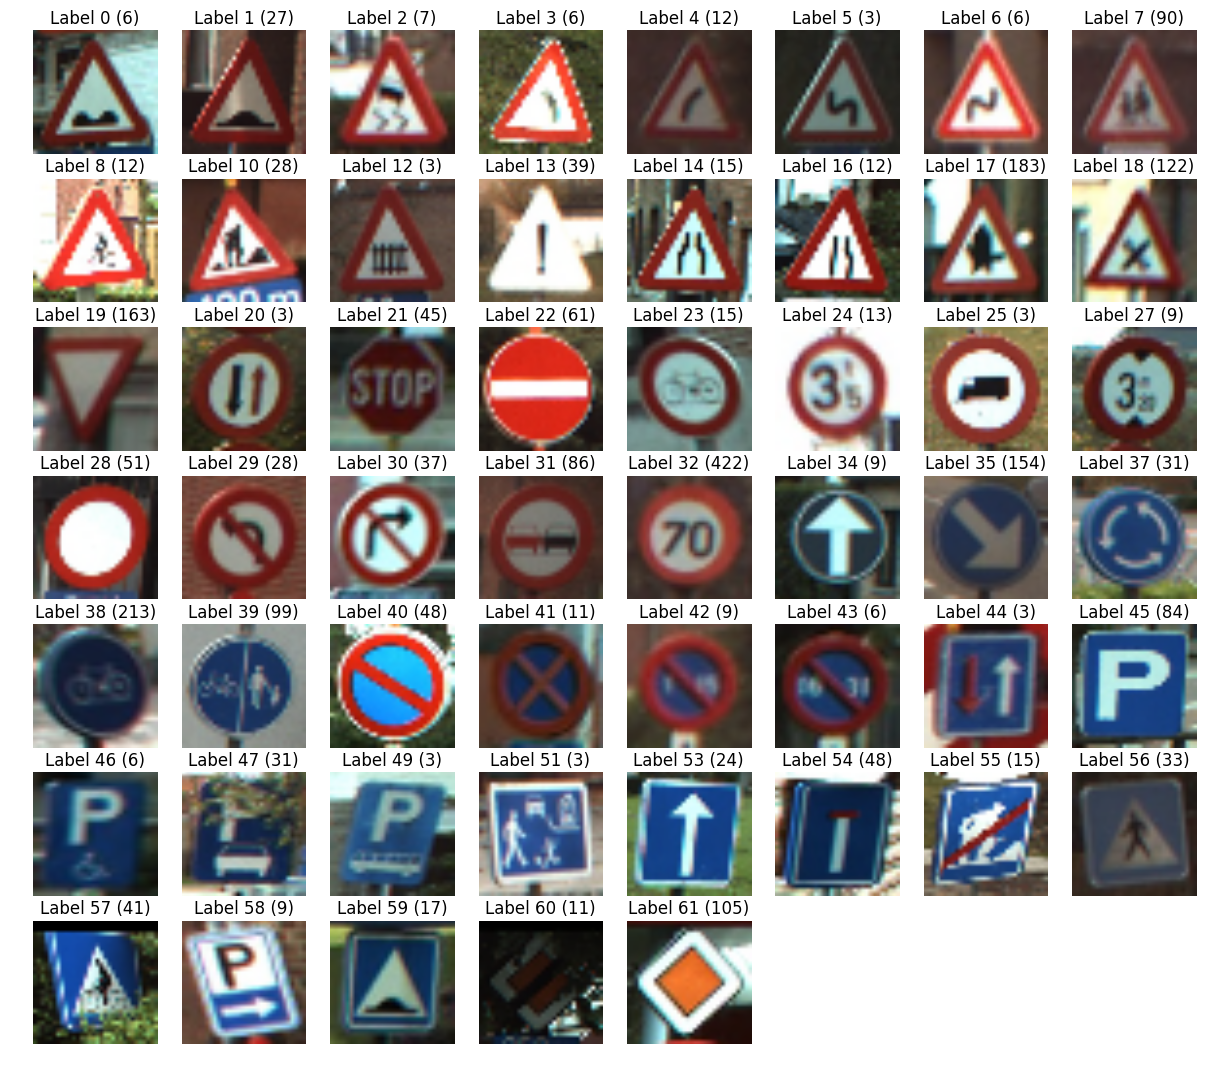

In [26]:
# transform the images
test_images32 = [skimage.transform.resize(image, (32, 32))for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [27]:
# Run the prediction against the full test set
predicted = session.run([predicted_labels], feed_dict={images_ph: test_images32})[0]

# Calculate how many matches we got.
match_count = sum([int(y==y_) for y,y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.739


In [28]:
# close the session. This will destroy the model
session.close()